### import the packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

### import data

In [2]:
data=pd.read_excel('D:/ds.xlsx')

### data inspection

In [3]:
data.columns

Index(['custid', 'region', 'townsize', 'gender', 'age', 'agecat', 'birthmonth',
       'ed', 'edcat', 'jobcat',
       ...
       'owncd', 'ownpda', 'ownpc', 'ownipod', 'owngame', 'ownfax', 'news',
       'response_01', 'response_02', 'response_03'],
      dtype='object', length=130)

In [4]:
# seperating continous and categorical variabkes
data_dict=pd.read_excel('D:/Data Dictionary.xlsx')
cat_var = list(data_dict['Categorical Variable'][~data_dict['Categorical Variable'].isna()])

In [5]:
len(cat_var)

84

In [6]:
num_var = [x for x in data.columns if x not in cat_var]

In [7]:
len(num_var)

46

### creating UDF's

In [8]:
def continuous_var_summary(x):
    return pd.Series([x.dtype, x.nunique(), x.count(), x.isnull().sum(), x.sum(), x.mean(),
                      x.median(), x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
            index = ['DataType', 'C', 'N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 
                           'P1', 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [9]:
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.nunique(), x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['C', 'N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [10]:
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [11]:
num_var.remove('custid')

In [12]:
data[num_var].apply(continuous_var_summary).T

DataType     C     N NMISS          SUM      MEAN    MEDIAN  \
age               int64    62  5000     0       235128   47.0256        47   
ed                int64    18  5000     0        72715    14.543        14   
income            int64   266  5000     0       273798   54.7596        38   
lninc           float64   266  5000     0      18499.5   3.69991   3.63759   
debtinc         float64   325  5000     0      49770.8   9.95416       8.8   
creddebt        float64  4950  5000     0      9286.63   1.85733  0.926437   
lncreddebt      float64  4941  4999     1     -652.137 -0.130454 -0.076106   
othdebt         float64  4973  5000     0      18272.3   3.65446   2.09854   
lnothdebt       float64  4972  4999     1      3483.88  0.696915  0.741537   
spoused           int64    22  5000     0        30564    6.1128        -1   
reside            int64     9  5000     0        11020     2.204         2   
pets              int64    20  5000     0        15337    3.0674         2   
pets_cats         int64     7  5000     0         2502    0.5004         0   
pets_dogs         int64     7  5000     0         1962    0.3924         0   
pets_birds        int64     6  5000     0          552    0.1104         0   
pets_reptiles     int64     7  5000     0          278    0.0556         0   
pets_small        int64     8  5000     0          573    0.1146         0   
pets_saltfish     int64     9  5000     0          233    0.0466         0   
pets_freshfish    int64    17  5000     0         9237    1.8474         0   
carvalue        float64   801  5000     0       116163   23.2326        17   
commutetime     float64    41  4998     2       126677   25.3455        25   
cardspent       float64  4760  5000     0  1.68601e+06   337.203    276.36   
card2spent      float64  4477  5000     0       804381   160.876    125.34   
tenure            int64    73  5000     0       191024   38.2048        38   
longmon         float64   866  5000     0      67357.2   13.4714      9.55   
lnlongmon       float64   866  5000     0      11443.9   2.28878   2.25654   
longten         float64  4437  4997     3  3.54223e+06   708.872       350   
lnlongten       float64  4437  4997     3      28039.7    5.6113   5.85793   
tollmon         float64   235  5000     0      66322.2   13.2645         0   
lntollmon       float64   233  2378  2622       7712.4   3.24323   3.22883   
tollten         float64  2323  5000     0  2.88916e+06   577.833         0   
lntollten       float64  2322  2378  2622      15658.6   6.58478   6.85801   
equipmon        float64   735  5000     0      64956.6   12.9913         0   
lnequipmon      float64   734  1704  3296       6134.8   3.60024   3.59868   
equipten        float64  1683  5000     0  2.35088e+06   470.176         0   
lnequipten      float64  1682  1704  3296      11497.4    6.7473   7.05056   
cardmon         float64   271  5000     0      77219.2   15.4438     13.75   
lncardmon       float64   270  3581  1419      10419.8   2.90973   2.90417   
cardten         float64   697  4998     2  3.60095e+06   720.478       425   
lncardten       float64   696  3578  1422      22993.3   6.42631   6.63988   
wiremon         float64   746  5000     0      53505.9   10.7012         0   
lnwiremon       float64   745  1344  3656      4845.12     3.605     3.598   
wireten         float64  1328  5000     0  2.10992e+06   421.985         0   
lnwireten       float64  1327  1344  3656      9150.13   6.80813   7.14719   
hourstv           int64    32  5000     0        98225    19.645        20   

                     STD          VAR       MIN         P1        P5  \
age              17.7703      315.785        18         18        20   
ed               3.28108      10.7655         6          8         9   
income           55.3775      3066.67         9          9        13   
lninc           0.747072     0.558116   2.19722    2.19722   2.56495   
debtinc          6.39978      40.9572         0        0.7       1

redefining contionous and categorical values

In [13]:
for i in ['reside', 'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small', 'pets_saltfish', 'pets_freshfish',
         'pets', 'spoused']:
    num_var.remove(i)

In [14]:
log_var = [x for x in data.columns if x[0:2]=='ln']

In [15]:
for i in log_var:
    num_var.remove(i)

In [16]:
num_var = num_var + ['cardtenure', 'card2tenure']

In [17]:
for i in  ['cardtenure', 'card2tenure']:
    num_var.remove(i)

In [18]:
cat_var = cat_var + ['reside', 'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small', 'pets_saltfish', 
                     'pets_freshfish', 'pets', 'spoused']

In [19]:
cat_var.remove('employ')

In [20]:
data.columns.difference(log_var)

Index(['active', 'address', 'addresscat', 'age', 'agecat', 'bfast',
       'birthmonth', 'callcard', 'callid', 'callwait',
       ...
       'tollfree', 'tollmon', 'tollten', 'townsize', 'union', 'voice', 'vote',
       'wireless', 'wiremon', 'wireten'],
      dtype='object', length=117)

In [21]:
pd.set_option('display.max_rows',None)
data[cat_var].apply(categorical_var_summary).T

C     N NMISS       MODE  FREQ PERCENT
region              5  5000     0          5  1027   20.54
townsize            5  4998     2          1  1436   28.73
gender              2  5000     0          1  2518   50.36
agecat              5  5000     0          4  1222   24.44
birthmonth         12  5000     0  September   458    9.16
edcat               5  5000     0          2  1567   31.34
jobcat              6  5000     0          2  1640    32.8
union               2  5000     0          0  4244   84.88
empcat              5  5000     0          2  1180    23.6
retire              2  5000     0          0  4262   85.24
inccat              5  5000     0          2  1797   35.94
default             2  5000     0          0  3829   76.58
jobsat              5  5000     0          3  1085    21.7
marital             2  5000     0          0  2599   51.98
spousedcat          6  5000     0         -1  2599   51.98
homeown             2  5000     0          1  3148   62.96
hometype            4  5000     0          1  2265    45.3
address            57  5000     0          0   245     4.9
addresscat          5  5000     0          3  1221   24.42
cars                9  5000     0          2  1607   32.14
carown              3  5000     0          1  3704   74.08
cartype             3  5000     0          0  2287   45.74
carcatvalue         4  5000     0          1  2399   47.98
carbought           3  5000     0          0  2901   58.02
carbuy              2  5000     0          0  3195    63.9
commute            10  5000     0          1  2855    57.1
commutecat          5  5000     0          1  2905    58.1
commutecar          2  5000     0          1  3395    67.9
commutemotorcycle   2  5000     0          0  4487   89.74
commutecarpool      2  5000     0          0  3641   72.82
commutebus          2  5000     0          0  2970    59.4
commuterail         2  5000     0          0  3627   72.54
commutepublic       2  5000     0          0  4523   90.46
commutebike         2  5000     0          0  4383   87.66
commutewalk         2  5000     0          0  3081   61.62
commutenonmotor     2  5000     0          0  4708   94.16
telecommute         2  5000     0          0  4060    81.2
reason              5  5000     0          9  4052   81.04
polview             7  5000     0          4  1733   34.66
polparty            2  5000     0          0  3093   61.86
polcontrib          2  5000     0          0  3808   76.16
vote                2  5000     0          1  2590    51.8
card                5  5000     0          4  1344   26.88
cardtype            4  5000     0          4  1260    25.2
cardbenefit         4  5000     0          3  1274   25.48
cardfee             2  5000     0          0  4051   81.02
cardtenure         41  5000     0          3   246    4.92
cardtenurecat       5  5000     0          5  2351   47.02
card2               5  5000     0          3  1384   27.68
card2type           4  5000     0          4  1319   26.38
card2benefit        4  5000     0          4  1294   25.88
card2fee            2  5000     0          0  4064   81.28
card2tenure        31  5000     0          2   304    6.08
card2tenurecat      5  5000     0          5  1923   38.46
active              2  5000     0          0  2670    53.4
bfast               3  5000     0          3  1875    37.5
churn               2  5000     0          0  3734   74.68
tollfree            2  5000     0          0  2622   52.44
equip               2  5000     0          0  3296   65.92
callcard            2  5000     0          1  3581   71.62
wireless            2  5000     0          0  3656   73.12
multline            2  5000     0          0  2558   51.16
voice               2  5000     0          0  3485    69.7
pager               2  5000     0          0  3782   75.64
internet            5  5000     0          0  2498   49.96
callid              2  5000     0          0  2624   52.48
callwait            2  5000     0          0  2605    52.1
forward 

In [22]:
print('Number of Continuous variables: ', len(num_var), ' | Number of Categorical Variables: ', len(cat_var))

Number of Continuous variables:  22  | Number of Categorical Variables:  93


### Outlier treatment

In [23]:
data[num_var]=data[num_var].apply(lambda x : x.clip(lower=x.quantile(0.01),upper=x.quantile(0.99)))

In [24]:
data[cat_var].astype('category', inplace = True)

region townsize gender agecat birthmonth edcat jobcat union empcat  \
0         1      2.0      1      2  September     3      1     1      1   
1         5      5.0      0      2        May     4      2     0      1   
2         3      4.0      1      6       June     2      2     0      5   
3         4      3.0      0      2        May     3      2     0      1   
4         2      2.0      0      3       July     3      2     0      1   
5         4      4.0      0      5     August     4      3     0      5   
6         2      5.0      1      5       July     2      1     0      3   
7         3      4.0      1      4    October     3      1     0      4   
8         2      3.0      1      6    October     2      1     0      4   
9         2      2.0      0      4       July     1      6     0      5   
10        4      1.0      1      5       July     4      1     0      3   
11        2      4.0      1      3    October     1      2     0      2   
12        5      2.0      0      4      March     1      1     0      4   
13        3      2.0      0      5    January     4      1     0      2   
14        2      1.0      1      6   December     5      4     1      5   
15        3      1.0      1      6   December     2      6     1      5   
16        1      1.0      1      5    October     4      4     0      5   
17        5      2.0      0      5        May     2      6     1      5   
18        5      5.0      1      3      April     1      1     0      2   
19        1      1.0      1      6       June     3      1     0      3   
20        3      3.0      0      5       June     3      1     0      2   
21        2      4.0      0      6  September     4      2     1      2   
22        4      1.0      0      5      April     2      6     0      5   
23        3      4.0      0      4     August     1      1     1      2   
24        1      3.0      0      4    October     2      1     0      2   
25        4      3.0      1      6   November     2      3     0      5   
26        5      4.0      1      3       June     3      2     0      1   
27        2      1.0      1      2      April     4      6     0      1   
28        3      1.0      1      6        May     3      1     0      5   
29        5      3.0      0      4      March     4      1     1      2   
30        3      5.0      0      5   December     2      3     0      5   
31        2      2.0      1      5      March     4      1     0      4   
32        1      1.0      1      5   February     1      2     1      2   
33        1      1.0      0      3    October     1      2     1      1   
34        3      3.0      0      5     August     5      2     0      4   
35        4      5.0      0      4     August     2      2     0      2   
36        3      1.0      0      4   February     5      5     0      5   
37        5      2.0      0      6      April     1      2     0      2   
38        2      3.0      1      4   February     5      1     1      2   
39        1      1.0      1      5        May     2      1     0      4   
40        1      2.0      1      5  September     2      3     0      3   
41        5      2.0      0      3      April     2      1     0      1   
42        5      4.0      0      6  September     1      3     0      5   
43        1      1.0      1      4   November     1      2     0      2   
44        5      1.0      0      4     August     4      2     0      1   
45        5      1.0      0      6   February     1      2     0      4   
46        3      1.0      1      4     August     4      2     0      2   
47        5      5.0      0      4   December     1      6     0      4   
48        5      4.0      0      2   December     3      3     0      1   
49        2      1.0      0      5   December     5      3     0      5   
50        3      3.0      1      3   December     2      6     0      3   
51        2      1.0      1      5        May     4      6     0      5   
52        2      2.0      0   

In [25]:
final_data = pd.concat([data[num_var], data[cat_var]], axis = 1)

### Missing value imputations

In [26]:
final_data = final_data.apply(missing_imputation)

### Creating Dummies

In [27]:
cat_dummies = pd.DataFrame()
for i in cat_var:
    col_dummies = pd.get_dummies(data[i],prefix=i,drop_first=True)
    cat_dummies = pd.concat([cat_dummies, col_dummies], axis = 1)

In [28]:
len(cat_dummies.columns)

407

### final data

In [29]:
final_data=pd.concat([data[num_var],cat_dummies],axis=1)

In [30]:
final_data['Limit']=final_data['cardspent']+final_data['card2spent']

In [31]:
final_data.drop(columns=['cardspent','card2spent'],inplace=True)

In [32]:
final_data.Limit

0        149.4600
1         77.5400
2        359.9700
3        359.4100
4        507.8300
5        228.2700
6        952.4600
7       1304.8000
8        467.8300
9        310.8100
10       811.0400
11       393.4300
12       732.7500
13       978.4400
14       273.1000
15       396.1200
16       402.1700
17      1207.8798
18       586.7800
19        40.8195
20       512.3600
21       347.2500
22       308.6600
23       744.0800
24       698.8800
25       293.1100
26       548.6700
27       304.5000
28       302.0100
29       479.8700
30       465.4300
31       156.9900
32       444.1400
33       454.3600
34       644.6700
35       766.8500
36       974.3500
37       262.7400
38        99.6100
39       439.0600
40       564.4200
41       558.4000
42       391.1300
43       351.2000
44       470.3500
45       617.0700
46       526.0200
47       338.4600
48       285.7600
49      1295.9300
50       355.0100
51       122.7800
52       345.6200
53       293.8200
54       472.7200
55       7

### Assumption check

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

1.5894956724921987

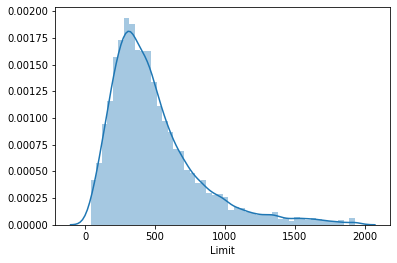

In [34]:
sns.distplot((final_data.Limit))
(final_data.Limit).skew()

The data is skewed as we have to transform it using Log transformation

-0.33838713901193473

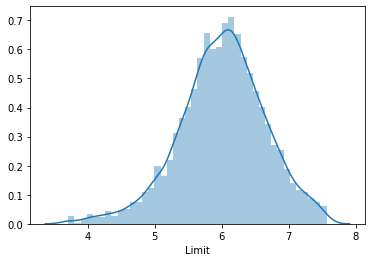

In [35]:
sns.distplot(np.log(final_data.Limit))
np.log(final_data.Limit).skew()

In [36]:
final_data['ln_Limit']=np.log(final_data.Limit)

In [37]:
final_data.drop(columns=['Limit'],inplace=True)

In [38]:
#Linearity: correlation matrix
corrm = final_data.corr()
corrm.to_excel('final.xlsx')

In [39]:
final_data.apply(continuous_var_summary)

age       ed   income  debtinc   creddebt   othdebt carvalue  \
DataType    int64    int64  float64  float64    float64   float64  float64   
C              62       14      223      280       4852      4875      767   
N            5000     5000     5000     5000       5000      5000     5000   
NMISS           0        0        0        0          0         0        0   
SUM        235128    72721   268150  49570.6    8791.84   17612.5   116011   
MEAN      47.0256  14.5442  53.6299  9.91412    1.75837   3.52251  23.2022   
MEDIAN         47       14       38      8.8   0.926437   2.09854       17   
STD       17.7703  3.24255  46.5677  6.24169    2.38068   4.22176  21.1298   
VAR       315.785  10.5141  2168.55  38.9587    5.66764   17.8233   446.47   
MIN            18        8        9      0.7  0.0331601  0.114299       -1   
P1             18        8        9      0.7  0.0331659  0.114312       -1   
P5             20        9       13      1.9   0.101088  0.287692       -1   
P10            23       10       16      2.8   0.175682  0.457997     2.49   
P25            31       12       24      5.1    0.38552  0.980301      9.2   
P50            47       14       38      8.8   0.926437   2.09854       17   
P75            62       17       67     13.6    2.06382   4.31478     31.1   
P90            72       19    109.1     18.6    4.29947   8.06205    52.91   
P95            76       20      147     22.2    6.37301    11.816       72   
P99            79       21      272     29.2      14.28   24.0625       92   
MAX            79       21   272.01     29.2    14.2804   24.0643   92.001   

         commutetime   tenure  longmon  ... spoused_16 spoused_17 spoused_18  \
DataType     float64    int64  float64  ...      uint8      uint8      uint8   
C                 29       72      800  ...          2          2          2   
N               4998     5000     5000  ...       5000       5000       5000   
NMISS              2        0        0  ...          0          0          0   
SUM           126610   191027  66363.2  ...        250        188        116   
MEAN         25.3322  38.2054  13.2726  ...       0.05     0.0376     0.0232   
MEDIAN            25       38     9.55  ...          0          0          0   
STD          5.75586  22.6609  11.5517  ...   0.217967   0.190246   0.150553   
VAR            33.13  513.516  133.442  ...  0.0475095  0.0361935  0.0226663   
MIN               13        1     1.85  ...          0          0          0   
P1                13        1     1.85  ...          0          0          0   
P5                16        4      2.9  ...          0          0          0   
P10               18        7      3.7  ...          0          0          0   
P25               21       18      5.7  ...          0          0          0   
P50               25       38     9.55  ...          0          0          0   
P75               29       59    16.55  ...          0          0          0   
P90               33       69       27  ...          0          0          0   
P95               35       72  36.7575  ...       0.05          0          0   
P99          40.0009       72     65.2  ...          1          1          1   
MAX            40.03       72   65.201  ...          1          1          1   

         spoused_19 spoused_20 spoused_21  spoused_22  spoused_23  spoused_24  \
DataType      uint8      uint8      uint8       uint8       uint8       uint8   
C                 2          2          2           2           2           2   
N              5000       5000       5000        5000        5000        5000   
NMISS             0          0          0           0           0           0   
SUM              90         59         20          14           9           3   
MEAN          0.018     0.0118      0.004      0.0028      0.0018      0.0006   
MEDIAN            0          0          0           0           0           0   
STD        0.132964   0.107996  0.0631252   0.

### feature selection based on importance using F - Regression

In [40]:
Feature = final_data[final_data.columns.difference(['ln_Limit'])]
Target = final_data['ln_Limit']

In [41]:
final_data.dropna(inplace = True)

In [42]:
final_data=final_data.apply(lambda x : x.clip(lower=x.quantile(0.01),upper=x.quantile(0.99)))

In [43]:
Feature=Feature.apply(missing_imputation)

In [44]:
F_Value, p_Value = f_regression(Feature,Target)

In [45]:
F_Regression_results = pd.concat([pd.Series(Feature.columns), 
                            pd.Series(F_Value), pd.Series(p_Value).round(5)], axis = 1)

# add the column names
F_Regression_results.columns = ['Feature', 'F_value', 'p_value']

In [46]:
F_Regression_results.sort_values(by  = 'p_value')

Feature     F_value  p_value
426               wireten   47.238867  0.00000
281              ownpda_1   24.093361  0.00000
276              owndvd_1  138.961746  0.00000
275               owncd_1  112.506000  0.00000
274               othdebt  364.096001  0.00000
260              jobcat_2   28.210152  0.00000
255                income  723.919844  0.00000
63               agecat_4   33.019025  0.00000
64               agecat_5   57.904400  0.00000
134                card_3   60.689795  0.00000
254              inccat_5  259.881595  0.00000
253              inccat_4  158.221448  0.00000
252              inccat_3   59.231653  0.00000
246             homeown_1   23.935886  0.00000
282               owntv_1   35.835560  0.00000
245              gender_1   31.206518  0.00000
242              equipmon   24.810371  0.00000
85          carcatvalue_1  438.273018  0.00000
86          carcatvalue_2   41.604843  0.00000
87          carcatvalue_3  361.750116  0.00000
88                card2_2   27.876455  0.00000
89                card2_3   38.551883  0.00000
232                    ed   48.632064  0.00000
228              creddebt  286.740254  0.00000
425               wiremon   37.760919  0.00000
202              carvalue  518.475671  0.00000
191              carown_1   77.540431  0.00000
190              carown_0  135.371565  0.00000
135                card_4   26.808170  0.00000
243              equipten   33.203983  0.00000
283              ownvcr_1  127.426879  0.00000
65               agecat_6   47.174884  0.00000
133                card_2   72.731632  0.00000
424            wireless_1   27.267016  0.00000
416               tollten   35.980696  0.00000
415               tollmon   27.298830  0.00000
385              retire_1  207.424619  0.00000
366              reason_2  113.476637  0.00000
247            hometype_2   19.468960  0.00001
384         response_03_1   19.137214  0.00001
277              ownfax_1   19.635497  0.00001
240              empcat_5   18.276845  0.00002
251              inccat_2   18.077723  0.00002
90                card2_4   16.320335  0.00005
284               pager_1   16.407936  0.00005
423                vote_1   15.863612  0.00007
81             callwait_1   15.775201  0.00007
259            internet_4   15.462095  0.00009
235               edcat_4   15.151556  0.00010
80               callid_1   15.123027  0.00010
227              confer_1   14.994199  0.00011
59           addresscat_4   14.869854  0.00012
414            tollfree_1   14.500000  0.00014
241               equip_1   13.813650  0.00020
91                card2_5   13.469856  0.00024
413                tenure   13.351348  0.00026
244             forward_1   13.125296  0.00029
186       cardtenurecat_5   13.045592  0.00031
233               edcat_2   12.752901  0.00036
236               edcat_5   12.698835  0.00037
34              address_4   10.787588  0.00103
368              reason_4   10.761307  0.00104
258            internet_3   10.505857  0.00120
136                card_5   10.152747  0.00145
422               voice_1   10.077012  0.00151
1               address_1    9.912996  0.00165
250               hourstv    9.847830  0.00171
268              jobsat_5    9.830559  0.00173
272            multline_1    9.723162  0.00183
280               ownpc_1    9.699904  0.00185
261              jobcat_3    9.564340  0.00199
114        card2tenure_26    9.343971  0.00225
67                bfast_3    9.079747  0.00260
126      card2tenurecat_2    9.010185  0.00270
278             owngame_1    8.950481  0.00279
279             ownipod_1    8.625537  0.00333
23              address_3    8.461739  0.00364
302                pets_8    8.326140  0.00392
192                cars_1    7.903525  0.00495
66                bfast_2    7.510708  0.00616
339       pets_reptiles_3    7.360858  0.00669
239              empcat_4    7.203178  0.00730
58           addresscat_3    7.180952  0.00739
57           addresscat_2    6.751582  0.00939
129      card2tenurecat

In [47]:
Features = list(F_Regression_results.loc[ F_Regression_results.p_value <= 0.002,'Feature' ])

In [48]:
len(Features)

71

In [49]:
Features+['card2tenure']

['address_1',
 'address_4',
 'addresscat_4',
 'agecat_4',
 'agecat_5',
 'agecat_6',
 'callid_1',
 'callwait_1',
 'carcatvalue_1',
 'carcatvalue_2',
 'carcatvalue_3',
 'card2_2',
 'card2_3',
 'card2_4',
 'card2_5',
 'card_2',
 'card_3',
 'card_4',
 'card_5',
 'cardtenurecat_5',
 'carown_0',
 'carown_1',
 'carvalue',
 'confer_1',
 'creddebt',
 'ed',
 'edcat_2',
 'edcat_4',
 'edcat_5',
 'empcat_5',
 'equip_1',
 'equipmon',
 'equipten',
 'forward_1',
 'gender_1',
 'homeown_1',
 'hometype_2',
 'hourstv',
 'inccat_2',
 'inccat_3',
 'inccat_4',
 'inccat_5',
 'income',
 'internet_3',
 'internet_4',
 'jobcat_2',
 'jobcat_3',
 'jobsat_5',
 'multline_1',
 'othdebt',
 'owncd_1',
 'owndvd_1',
 'ownfax_1',
 'ownpc_1',
 'ownpda_1',
 'owntv_1',
 'ownvcr_1',
 'pager_1',
 'reason_2',
 'reason_4',
 'response_03_1',
 'retire_1',
 'tenure',
 'tollfree_1',
 'tollmon',
 'tollten',
 'voice_1',
 'vote_1',
 'wireless_1',
 'wiremon',
 'wireten',
 'card2tenure']

### Remove the multi colinear variables - VIF

In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [51]:
['wiremon','carcatvalue_1','equipmon','income','carvalue','tollmon']

['wiremon', 'carcatvalue_1', 'equipmon', 'income', 'carvalue', 'tollmon']

In [52]:
for i in ['wiremon','carcatvalue_1','equipmon','income','carvalue','tollmon']:
    Features.remove(i)

In [53]:
model_param = 'ln_Limit ~ ' + ' + '.join(Features)

In [54]:
y, X = dmatrices(model_param, final_data, return_type = 'dataframe')

In [55]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

Features  VIF Factor
0         Intercept  163.632818
1         address_1    1.127434
2         address_4    1.084344
3      addresscat_4    1.212086
4          agecat_4    2.104457
5          agecat_5    2.774963
6          agecat_6    3.549110
7          callid_1    2.220644
8        callwait_1    2.163291
9     carcatvalue_2    2.254321
10    carcatvalue_3    4.109703
11          card2_2    2.104090
12          card2_3    2.177594
13          card2_4    2.304959
14          card2_5    1.464051
15           card_2    1.983779
16           card_3    1.969747
17           card_4    2.211471
18           card_5    1.294066
19  cardtenurecat_5    3.394189
20         carown_0    2.652530
21         carown_1    2.784042
22         confer_1    2.249907
23         creddebt    1.872152
24               ed    3.539508
25          edcat_2    1.271692
26          edcat_4    2.478383
27          edcat_5    2.218366
28         empcat_5    2.035342
29          equip_1    3.926317
30         equipten    4.424190
31        forward_1    2.147652
32         gender_1    1.022721
33        homeown_1    2.162092
34       hometype_2    2.145158
35          hourstv    1.360405
36         inccat_2    2.392038
37         inccat_3    3.283084
38         inccat_4    4.123263
39         inccat_5    4.371107
40       internet_3    1.234348
41       internet_4    1.413985
42         jobcat_2    1.289985
43         jobcat_3    1.094430
44         jobsat_5    1.138543
45       multline_1    1.628512
46          othdebt    2.174581
47          owncd_1    1.563792
48         owndvd_1    1.586475
49         ownfax_1    1.666413
50          ownpc_1    1.579089
51         ownpda_1    1.677145
52          owntv_1    1.664146
53         ownvcr_1    1.597556
54          pager_1    2.189656
55         reason_2    1.023663
56         reason_4    1.013032
57    response_03_1    1.034144
58         retire_1    2.743208
59           tenure    4.733869
60       tollfree_1    3.287994
61          tollten    3.507145
62          voice_1    2.133324
63           vote_1    1.041163
64       wireless_1    4.035763
65          wireten    4.714462

In [56]:
Features = list(vif.loc[ vif.Features != 'Intercept', 'Features'])

In [57]:
Features

['address_1',
 'address_4',
 'addresscat_4',
 'agecat_4',
 'agecat_5',
 'agecat_6',
 'callid_1',
 'callwait_1',
 'carcatvalue_2',
 'carcatvalue_3',
 'card2_2',
 'card2_3',
 'card2_4',
 'card2_5',
 'card_2',
 'card_3',
 'card_4',
 'card_5',
 'cardtenurecat_5',
 'carown_0',
 'carown_1',
 'confer_1',
 'creddebt',
 'ed',
 'edcat_2',
 'edcat_4',
 'edcat_5',
 'empcat_5',
 'equip_1',
 'equipten',
 'forward_1',
 'gender_1',
 'homeown_1',
 'hometype_2',
 'hourstv',
 'inccat_2',
 'inccat_3',
 'inccat_4',
 'inccat_5',
 'internet_3',
 'internet_4',
 'jobcat_2',
 'jobcat_3',
 'jobsat_5',
 'multline_1',
 'othdebt',
 'owncd_1',
 'owndvd_1',
 'ownfax_1',
 'ownpc_1',
 'ownpda_1',
 'owntv_1',
 'ownvcr_1',
 'pager_1',
 'reason_2',
 'reason_4',
 'response_03_1',
 'retire_1',
 'tenure',
 'tollfree_1',
 'tollten',
 'voice_1',
 'vote_1',
 'wireless_1',
 'wireten']

### Splitting the Data for model building

In [58]:
from sklearn.model_selection import train_test_split


In [59]:
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [60]:
train, test = train_test_split(final_data, test_size = 0.3, random_state = 1)

In [61]:
print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  3496  |  No of obs in testing:  1499


In [62]:
Features.remove('equipten')

### Building Model using OLS (Ordinary  Least Squares)

In [63]:
formula_m0 = 'ln_Limit ~ ' + ' + '.join( Features )

In [64]:
lm0 = smf.ols( formula_m0, train ).fit()

In [65]:
print(lm0.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Limit   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     28.62
Date:                Sun, 05 Jul 2020   Prob (F-statistic):          3.44e-267
Time:                        23:43:52   Log-Likelihood:                -2670.6
No. Observations:                3496   AIC:                             5471.
Df Residuals:                    3431   BIC:                             5872.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.6102      0.119     

### removing variables having p value >0.05

In [66]:
pvalues = lm0.pvalues<0.05

pvalue_index = pvalues.index.values

pvalues = list(pvalues)

# pvalues_greater =[]
# for idx, i in enumerate(pvalues):
#     print(idx)
#     if i == False:
#         pvalues_greater.append(idx)

In [67]:
pvalues_df = pd.DataFrame({"colnames": pvalue_index, "value": pvalues})

In [68]:
pvalues_df
pvalues_greater = pvalues_df[pvalues_df['value']==False]['colnames']

In [69]:
Features

['address_1',
 'address_4',
 'addresscat_4',
 'agecat_4',
 'agecat_5',
 'agecat_6',
 'callid_1',
 'callwait_1',
 'carcatvalue_2',
 'carcatvalue_3',
 'card2_2',
 'card2_3',
 'card2_4',
 'card2_5',
 'card_2',
 'card_3',
 'card_4',
 'card_5',
 'cardtenurecat_5',
 'carown_0',
 'carown_1',
 'confer_1',
 'creddebt',
 'ed',
 'edcat_2',
 'edcat_4',
 'edcat_5',
 'empcat_5',
 'equip_1',
 'forward_1',
 'gender_1',
 'homeown_1',
 'hometype_2',
 'hourstv',
 'inccat_2',
 'inccat_3',
 'inccat_4',
 'inccat_5',
 'internet_3',
 'internet_4',
 'jobcat_2',
 'jobcat_3',
 'jobsat_5',
 'multline_1',
 'othdebt',
 'owncd_1',
 'owndvd_1',
 'ownfax_1',
 'ownpc_1',
 'ownpda_1',
 'owntv_1',
 'ownvcr_1',
 'pager_1',
 'reason_2',
 'reason_4',
 'response_03_1',
 'retire_1',
 'tenure',
 'tollfree_1',
 'tollten',
 'voice_1',
 'vote_1',
 'wireless_1',
 'wireten']

In [70]:
final_features = set(Features).difference(set(pvalues_greater))
pvalues_df

colnames  value
0         Intercept   True
1         address_1  False
2         address_4  False
3      addresscat_4  False
4          agecat_4  False
5          agecat_5  False
6          agecat_6  False
7          callid_1  False
8        callwait_1  False
9     carcatvalue_2  False
10    carcatvalue_3  False
11          card2_2   True
12          card2_3   True
13          card2_4   True
14          card2_5   True
15           card_2   True
16           card_3   True
17           card_4   True
18           card_5   True
19  cardtenurecat_5  False
20         carown_0   True
21         carown_1  False
22         confer_1  False
23         creddebt  False
24               ed  False
25          edcat_2  False
26          edcat_4  False
27          edcat_5   True
28         empcat_5  False
29          equip_1  False
30        forward_1  False
31         gender_1   True
32        homeown_1  False
33       hometype_2  False
34          hourstv  False
35         inccat_2   True
36         inccat_3   True
37         inccat_4   True
38         inccat_5   True
39       internet_3   True
40       internet_4   True
41         jobcat_2  False
42         jobcat_3  False
43         jobsat_5  False
44       multline_1  False
45          othdebt  False
46          owncd_1  False
47         owndvd_1  False
48         ownfax_1  False
49          ownpc_1  False
50         ownpda_1  False
51          owntv_1  False
52         ownvcr_1   True
53          pager_1  False
54         reason_2   True
55         reason_4   True
56    response_03_1  False
57         retire_1  False
58           tenure  False
59       tollfree_1  False
60          tollten  False
61          voice_1  False
62           vote_1  False
63       wireless_1  False
64          wireten  False

In [71]:
final_features

{'card2_2',
 'card2_3',
 'card2_4',
 'card2_5',
 'card_2',
 'card_3',
 'card_4',
 'card_5',
 'carown_0',
 'edcat_5',
 'gender_1',
 'inccat_2',
 'inccat_3',
 'inccat_4',
 'inccat_5',
 'internet_3',
 'internet_4',
 'ownvcr_1',
 'reason_2',
 'reason_4'}

In [72]:
Features=final_features

In [73]:
formula_m0 = 'ln_Limit ~ ' + ' + '.join( Features )

In [74]:
lm0 = smf.ols( formula_m0, train ).fit()

In [75]:
print(lm0.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Limit   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     88.47
Date:                Sun, 05 Jul 2020   Prob (F-statistic):          6.42e-292
Time:                        23:43:54   Log-Likelihood:                -2699.0
No. Observations:                3496   AIC:                             5440.
Df Residuals:                    3475   BIC:                             5569.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4994      0.048    136.828      0.0

### Predicting models

In [76]:
train.loc[:, 'pred_Limit'] = np.exp( lm0.predict(train) )

C:\Users\prash\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\prash\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [77]:
test.loc[:, 'pred_Limit'] = np.exp( lm0.predict(test) )

In [78]:
train['Limit']=np.exp(train.ln_Limit)
test['Limit']=np.exp(test.ln_Limit)

C:\Users\prash\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\prash\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
train['Limit']

65       785.060000
177      726.170000
4605     285.390000
2472     156.670000
2989    1036.060000
26       548.670000
2455     316.310000
525      293.720000
3587     285.420000
1255     299.890000
4674     467.370000
1147     741.910000
2040     897.710000
321      216.420000
3758     241.100000
664      358.540000
4320     306.010000
4749     339.020000
2103     460.110000
3710     290.710000
2027     516.840000
332      491.790000
4010     291.160000
2822     260.380000
3981      67.247712
3766     266.750000
598      369.300000
4844     745.030000
386      757.590000
4572    1225.080000
1461     490.740000
2429     747.940000
2827     705.970000
1786     753.990000
1789     944.340000
228     1645.765766
1030     127.050000
4766     762.290000
498      449.800000
3893     885.740000
903      534.510000
3771    1537.309800
701      554.520000
3154     215.450000
3751    1645.765766
2865     200.430000
4732     354.560000
4403     950.370000
4177     263.500000
1239     669.530000


In [80]:
MAE_train = mean_absolute_error(train.Limit, train.pred_Limit)



In [81]:
MAE_test = mean_absolute_error(test.Limit, test.pred_Limit)

In [82]:
test.Limit

1979     863.440000
4853     295.040000
3615     320.840000
3932     269.120000
4431     384.280000
3756     806.300000
958      386.450000
1496     199.340000
1849     326.810000
2231     291.300000
2100     847.900000
3737     681.290000
610      170.420000
4076     340.030000
1366     543.510000
4416     111.380000
3382     721.250000
1659     649.280000
644      141.090000
4932    1576.350000
1839     350.380000
1547     408.370000
4317     323.660000
1382     326.840000
1575     469.010000
1422     567.100000
3347     304.160000
1412     285.570000
1761     861.130000
886      468.650000
1510     414.070000
3854     349.210000
1346     567.870000
1215     827.120000
2032     477.370000
4183     512.360000
4051     337.640000
4261     549.520000
4577     289.450000
3545     107.360000
3511     115.560000
1827     306.670000
2392     551.210000
4118     291.700000
1615     582.080000
2157     275.350000
1440    1107.890000
2894     664.890000
2995    1645.765766
2721     214.200000


### model validation - for accuracies after predictions

In [83]:
print('MAE of training data: ', MAE_train,  ' | ', 'MAE of testing data: ', MAE_test)

MAE of training data:  188.5200886609359  |  MAE of testing data:  180.84878301684364


In [84]:
MAPE_train = np.mean(np.abs(train['Limit'] - train['pred_Limit'])/train['Limit'])
MAPE_test = np.mean(np.abs(test['Limit'] - test['pred_Limit'])/test['Limit'])

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  0.47170728715421173  |  MAPE of testing data:  0.46564898596477006


### Key drivers obtained by Ols method are:

In [85]:
print( Features)

{'edcat_5', 'card_5', 'inccat_4', 'inccat_5', 'carown_0', 'card2_3', 'gender_1', 'reason_2', 'card_4', 'card2_4', 'inccat_3', 'internet_4', 'card2_5', 'card_2', 'internet_3', 'card_3', 'ownvcr_1', 'inccat_2', 'reason_4', 'card2_2'}


### Using RandomForestRegressor for predicting Limit

In [86]:
from sklearn import metrics

In [87]:
from sklearn.ensemble import RandomForestRegressor

In [88]:
from sklearn.model_selection import  GridSearchCV

In [89]:
Feat=final_data.columns.difference(['Limit','ln_Limit'])

In [90]:
final_data['Limit']=np.exp(final_data.ln_Limit)

In [91]:
train_x,test_x,train_y,test_y=train_test_split(final_data[Feat],final_data['Limit'],test_size=0.3,random_state=1234)

In [92]:
final_data[Feat].columns

Index(['active_1', 'address_1', 'address_10', 'address_11', 'address_12',
       'address_13', 'address_14', 'address_15', 'address_16', 'address_17',
       ...
       'townsize_2.0', 'townsize_3.0', 'townsize_4.0', 'townsize_5.0',
       'union_1', 'voice_1', 'vote_1', 'wireless_1', 'wiremon', 'wireten'],
      dtype='object', length=427)

### Using GridSearch to get best n_estimators

In [93]:
params={'n_estimators':[100,200,300,400,500]}

In [94]:
grid=GridSearchCV(RandomForestRegressor(),param_grid=params,cv=6,n_jobs=-1)

In [95]:
grid.fit(train_x,train_y)

GridSearchCV(cv=6, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300, 4

In [96]:
grid.best_params_

{'n_estimators': 200}

### Creating Model

In [97]:
rt=RandomForestRegressor(n_estimators=400,n_jobs=-1)

In [98]:
rt.fit(train_x,train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [99]:
from sklearn import metrics

### predicting Limit

In [100]:
rt.predict(test_x)

array([516.89077661, 498.96466016, 387.92029956, ..., 422.46563284,
       445.26350173, 738.89943281])

### model validation - for accuracies after predictions

In [101]:
mae_test=metrics.mean_absolute_error(rt.predict(test_x),test_y)

In [102]:
mae_train=metrics.mean_absolute_error(rt.predict(train_x),train_y)

In [103]:
print('MAE of training data: ', mae_train,  ' | ', 'MAE of testing data: ', mae_test)

MAE of training data:  75.68737208144495  |  MAE of testing data:  205.2634221121031


In [104]:
mse_test=metrics.mean_squared_error(rt.predict(test_x),test_y)

In [105]:
mse_train=metrics.mean_squared_error(rt.predict(train_x),train_y)

In [106]:
print('MSE of training data: ', mse_train,  ' | ', 'MSE of testing data: ', mse_test)

MSE of training data:  10285.837555545446  |  MSE of testing data:  75644.32004632115


### Calculating R-sq of the model 

In [107]:
test_ssr=(rt.predict(test_x)-test_y.mean())**2
test_sse=(test_y-rt.predict(test_x))**2
test_sst=test_ssr+test_sse
test_r2=test_ssr.sum()/test_sst.sum()
test_r2

0.2402037624773424

In [108]:
Feature_importances = pd.DataFrame(rt.feature_importances_,
                                   index = train_x.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [109]:
Feature_importances.head(15)

importance
income         0.185719
creddebt       0.030055
card_2         0.026508
card_3         0.026460
carvalue       0.025839
othdebt        0.020834
card_4         0.020679
debtinc        0.019690
age            0.019472
reason_2       0.019050
hourstv        0.018536
longmon        0.018527
commutetime    0.018308
cardmon        0.015362
longten        0.015227

### Conclusion:

-- The R-sq of OLS method was much higher than that of Random Forest Regressor. 


-- We will choose the OLS method over Random Forest Regressor.


-- The accuracy of OLS was also Good as compared to the Random Forest.